# Pre-processing

Steps in pre-processing:
1. Import face detection library fdet, which uses the SOTA RetinaFace detection model.
2. Import social media faces file paths (age_gender_data.csv) which contain the file path to the image, the age label, and the gender label
3. Run the RetinaFace detector over each image to get the bounding box of the face. If there is more than one face, it will take the one with the highest probability.
4. Based on the bounding box of the face, crop out the face but leave a 10% spacing on all edges.
5. Resize the face to a square by padding the shorter dimension with black pixels, then resize to (150, 150)
6. Create new paths and save the new image to the paths. Create a new dataframe to store the new paths

## Set up environment and Load data

In [ ]:
!pip install opencv-python
!pip install fdet

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import cv2
from PIL import Image
from fdet import RetinaFace
detector = RetinaFace(backbone='MOBILENET')

import time
import math

import warnings
warnings.simplefilter("ignore")

import pandas as pd

In [2]:
datapath = "age_gender_data.csv"
df = pd.read_csv(datapath)

In [3]:
print(df.shape)
df.head()

(106972, 3)


,path,gender,age
0,data/UTKFace/14_1_0_20170109205344937.jpg.chip...,F,14
1,data/UTKFace/4_1_0_20170119144520789.jpg.chip.jpg,F,4
2,data/UTKFace/17_0_0_20170116205532920.jpg.chip...,M,17
3,data/UTKFace/3_1_0_20170109192803099.jpg.chip.jpg,F,3
4,data/UTKFace/14_1_0_20170109204620092.jpg.chip...,F,14


Functions for visualisation

In [ ]:
def show_face(img):
    plt.imshow(img)
    plt.show()
    
def show_from_path(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    show_face(image)

## Detect Faces

Function to take in the raw image path detect the face, and crop out the face. Padding is added to ensure the face is a square.

In [ ]:
def detect_and_crop_face(imgpath):
    image = cv2.imread(imgpath)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    detected = detector.detect(image)
    
    if len(detected) > 0:
        x, y, w, h = detected[0]['box']
        x, y, w, h = max(int(x - w * 0.1), 0), max(int(y - h * 0.1), 0), int(w * 1.2), int(h * 1.2)
        crop = image[y:y+h,x:x+w]
        im = Image.fromarray(crop)
        top, bottom, left, right = 0, 0, 0, 0
        if im.size[0] > im.size[1]:
            top = math.floor((im.size[0] - im.size[1])/2)
            bottom = math.ceil((im.size[0] - im.size[1])/2)
        elif im.size[0] < im.size[1]:
            left = math.floor((im.size[1] - im.size[0])/2)
            right = math.ceil((im.size[1] - im.size[0])/2)
        im = cv2.copyMakeBorder(np.array(im), top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0,0,0])
        img = cv2.resize(im, (150, 150))
        return img
    else:
        return "no face detected"

Visualise the original face and the cropped image to be used for training

In [ ]:
def visualise_detector(path):
    print('Original Image')
    show_from_path(path)

    start = time.time()
    img = detect_and_crop_face(path)
    end = time.time()
    print(f"Time taken for detection: {end - start}")

    if img == 'no face detected':
        print('No Face Detected')
    else:
        print("Face Detected")
        show_face(img)

Examples of Original and Detected Face

Original Image


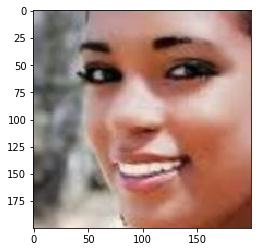

Time taken for detection: 0.018637895584106445
Face Detected


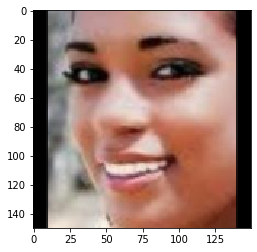

In [ ]:
path = df['path'].iloc[np.random.randint(100000)]
visualise_detector(path)

Original Image


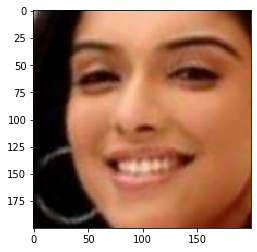

Time taken for detection: 0.07550573348999023
Face Detected


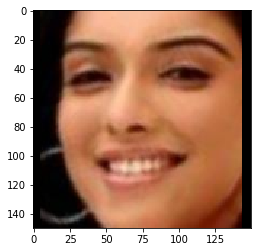

In [ ]:
path = df['path'].iloc[np.random.randint(100000)]
visualise_detector(path)

Original Image


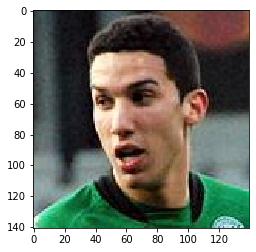

Time taken for detection: 0.059575557708740234
Face Detected


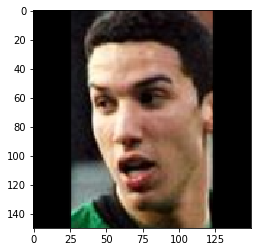

In [ ]:
path = df['path'].iloc[np.random.randint(100000)]
visualise_detector(path)

Original Image


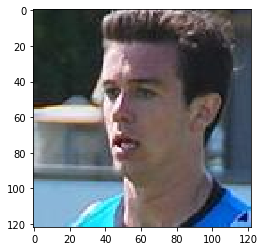

Time taken for detection: 0.14473700523376465
Face Detected


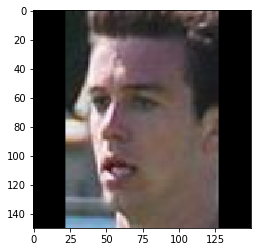

In [ ]:
path = df['path'].iloc[np.random.randint(100000)]
visualise_detector(path)

## Detect faces in dataset, then save images to folder and paths to csv

New df to store the paths and labels of the detected faces

In [ ]:
detected_df = pd.DataFrame(columns=['path', 'age', 'gender'])
not_detected_df = pd.DataFrame(columns=['path', 'age', 'gender'])

Loop to detect and pre-process the faces, store them in a new folder, and save the paths to the df

In [ ]:
detected_count, not_detected_count = 0, 0

for row in range(df.shape[0]):
    imgpath = df.iloc[row]['path']
    age = df.iloc[row]['age']
    gender = df.iloc[row]['gender']
    
    result = detect_and_crop_face(imgpath)
    
    if result == "no face detected":
        not_detected_count += 1
        image = cv2.imread(imgpath)
        new_path = f'final_train_test_data/no_face_detected/image_{not_detected_count}.jpg'
        cv2.imwrite(new_path, image)
        not_detected_df = not_detected_df.append({'path': new_path, 'age': age, 'gender': gender}, ignore_index=True)
    else:
        detected_count += 1
        result = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)
        new_path = f'final_train_test_data/face_detected/image_{detected_count}.jpg'
        cv2.imwrite(new_path, result)
        detected_df = detected_df.append({'path': new_path, 'age': age, 'gender': gender}, ignore_index=True)

In [22]:
print(detected_df.shape)
detected_df.head()

(106415, 3)


,Path,age,gender
0,final_train_test_data/face_detected/image_1.jpg,F,14
1,final_train_test_data/face_detected/image_2.jpg,M,22
2,final_train_test_data/face_detected/image_3.jpg,M,53
3,final_train_test_data/face_detected/image_4.jpg,M,55
4,final_train_test_data/face_detected/image_5.jpg,M,41


In [25]:
print(not_detected_df.shape)
not_detected_df.head()

(557, 3)


,Path,age,gender
0,final_train_test_data/no_face_detected/image_1...,F,55
1,final_train_test_data/no_face_detected/image_2...,M,27
2,final_train_test_data/no_face_detected/image_3...,F,32
3,final_train_test_data/no_face_detected/image_4...,M,25
4,final_train_test_data/no_face_detected/image_5...,F,41


In [ ]:
detected_df.to_csv('age_gender_detected.csv', index=False)
not_detected_df.to_csv('age_gender_not_detected.csv', index=False)